# 1.2 Naive RAG 에이전트 (feat. PDF 전처리)

- LangGraph를 활용하여 Naive RAG 에이전트 구현.

## 환경설정
- RAG 파이프라인을 위해 필요한 패키지들을 설치합니다

In [14]:
%pip install -qU pdfplumber langchain-community langchain-text-splitters nest_asyncio langchain

Note: you may need to restart the kernel to use updated packages.


In [1]:
import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv()

True

### ❶ RAG Process: 사전작업(Pre-processing) - 1~4 단계

![rag-1-graphic](./Images/rag-graphic-1.png)

사전 작업 단계에서는 데이터 소스를 Vector DB (저장소) 에 문서를 로드-분할-임베딩-저장 하는 4단계를 진행합니다.

- 1단계 문서로드(Document Load): 문서 내용을 불러옵니다.
- 2단계 분할(Text Split): 문서를 특정 기준(Chunk) 으로 분할합니다.
- 3단계 임베딩(Embedding): 분할된(Chunk) 를 임베딩하여 저장합니다.
- 4단계 벡터DB 저장: 임베딩된 Chunk 를 DB에 저장합니다.

- `PyPDFLoader`를 사용해 전처리된 데이터를 확인합니다

In [1]:
from langchain_community.document_loaders import PDFPlumberLoader

pdf_file_path = "./documents/청년월세지원.pdf"
loader = PDFPlumberLoader(pdf_file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [2]:
pages[3]

Document(metadata={'source': './documents/청년월세지원.pdf', 'file_path': './documents/청년월세지원.pdf', 'page': 3, 'total_pages': 10, 'Author': '', 'CreationDate': "D:20250602150647+09'00'", 'ModDate': "D:20250602150647+09'00'", 'Producer': 'Microsoft: Print To PDF', 'Title': '2025D ˝¸Ü \x00DÔ8ÀÐ ¨Ñ õà8.hwpx'}, page_content='예시1) 신청인의 건강보험이 직장가입자(가구원수 1인)로 부과\n⇒ 신청인의 ’25년 3월~5월 건강보험료 납부액 평균이 127,230원 이하이면 요건 충족\n예시2) 신청인의 건강보험이 피부양자(건강보험 상 부모 등의 세대원으로 등록)이며\n부양자의 건강보험이 직장가입자(가구원수 3인)로 부과\n⇒ 부양자의 ’25년 3월~5월 건강보험료 납부액 평균이 271,459원 이하이면 요건 충족\n※ 건강보험료 본인부담금 중 노인장기요양보험료 제외\n< 2025년 기준 중위소득별 건강보험료 소득판정 기준표 >\n(단위 : 원)\n기준 건강보험료 부과액\n가구원수 소득기준\n중위소득 직장가입자 지역가입자 혼합\n1인 2,871,000 102,613 22,380 -\n2인 4,720,000 168,410 105,787 170,193\n3인 6,031,000 215,933 151,146 219,196\n4인 7,318,000 261,360 208,471 266,302\n120% 5인 8,530,000 302,462 260,307 311,031\n이하 6인 9,678,000 354,964 320,449 369,517\n7인 10,787,000 386,684 357,963 407,092\n8인 11,895,000 431,294 411,250 461,699\n9인 13,003,000 461,699 447,279 506,0

- 데이터 전처리를 위한 [py-zerox](https://www.piwheels.org/project/py-zerox/) 패키지를 설치합니다

In [ ]:
%pip install -q py-zerox

Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      + meson setup /private/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/pip-install-gi8o9u6u/python-poppler_c259ca0648404c0eb61ff968f2a6a317 /private/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/pip-install-gi8o9u6u/python-poppler_c259ca0648404c0eb61ff968f2a6a317/.mesonpy-oe66b8gy -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/private/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/pip-install-gi8o9u6u/python-poppler_c259ca0648404c0eb61ff968f2a6a317/.mesonpy-oe66b8gy/meson-python-native-file.ini
      The Meson build system
      Version: 1.10.0
      Source dir: /pr

In [4]:
from pyzerox import zerox
import os
import json
import asyncio

### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###

## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
kwargs = {}

## Vision 모델에 사용할 시스템 프롬프트
custom_system_prompt = None

model = "gpt-4o-mini"

# Define main async entrypoint
async def main():
    file_path = "./documents/청년월세지원.pdf" ## local filepath and file URL supported

    ## process only some pages or all
    select_pages = None ## None for all, but could be int or list(int) page numbers (1 indexed)

    output_dir = "./documents" ## directory to save the consolidated markdown file
    result = await zerox(file_path=file_path, model=model, output_dir=output_dir,
                        custom_system_prompt=custom_system_prompt,select_pages=select_pages, **kwargs)
    return result


# run the main function:
result = asyncio.run(main())

# print markdown result
print(result)

/opt/anaconda3/envs/AgentTuto/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content="I'm doin...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [field_name='choices', input_value=Choices(finish_reason='le...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
/opt/anaconda3/envs/AgentTuto/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content="```markd...: None}, annotations=[]), input_type=Message])
  Py

ZeroxOutput(completion_time=26593.208000000002, file_name='청년월세지원', input_tokens=368770, output_tokens=5244, pages=[Page(content="# 2025년 서울시 청년월세지원 모집 공고\n\n서울시에서는 “서울특별시 청년주거 기본 조례 제7조”에 의거 청년의 주거비 부담 완화를 위해 다음과 같이 2025년 '서울시 청년월세지원 사업' 참여자를 모집하오니 많은 참여 바랍니다.\n\n2025년 6월 4일  \n서울특별시장\n\n## 1. 사업 개요\n\n- **사업명:** 2025년 서울시 청년월세지원 사업\n- **지원대상:** 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구  \n  ※ 서울시 청년월세지원 기수혜자 및 국토교통부 청년희망시스템 특례지원 수혜 중인 자, '25년 자치구 자체 청년월세지원 사업(운평, 광진 등) 지원자로 선정된 사람은 지원 불가\n\n## 지원내용\n\n- **지원금액:** 월 최대 20만원(최대 12개월/240만원) ※ 생애 1회  \n  - 20만원 미만 월세 계약은 임대차계약서에 표기된 월세 금액만 지원(천원 단위 절삭 예시 차임) 108,000원 이상은 10만원 지원/ 관리비가 포함된 경우 관리비를 제외하고 월세만 지원\n  - 서울형 주택바우처 수급자인 경우, 바우처 수급액을 제외한 차액 지급\n  - 서울시 청년월세 지원 대상자 최종 선정 후 12개월간 지급\n", content_length=594, page=1), Page(content="# 신청접수\n- 신청기간: 2025. 6. 11.(수) 10:00 ~ 6. 24.(화) 18:00 (마감)\n- 신청인원: 15,000명\n- 신청방법: 서울주거포털 온라인 신청\n\n## 선정 및 지급\n- 선정방법: 임차보증금-월세 및 소득기준 4개 구간으로 나누어 선정하고 인원 초과시 구간별 전산 추첨\n- 지급방법: 각월 25일 전후로 계좌 입금\n  - 지급일정: 

- zerox를 활용한 전처리 후 생성된 마크다운 파일을 LangGraph에서 활용하기 위해 [unstructured](https://unstructured.io/) 패키지를 설치합니다
- `UnstructuredMarkdownLoader`를 사용해 전처리된 데이터를 확인합니다
    - `loader`활용 시 테이블 구조가 사라지는 것을 확인할 수 있습니다

In [5]:
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

In [8]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "./documents/청년월세지원.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)

In [14]:
document_list[4]

Document(metadata={'source': './documents/청년월세지원.md'}, page_content='선정방법 : 임차보증금·월세 및 소득기준, 4개 구간으로 나누어 선정 인원 초과 시, 구간별 전산추첨 선정\n\n구간별 미달인 경우, 1구간부터 4구간 순으로 추가 선정\n\n선정기준은 월세액, 임대차계약서에 표기된 차임(월세)액으로 함 (관리비 제외)\n\n차임(월세) 기준 월세 60만원 초과 시 보증금 월세 환산액(5.0%) 합산\n\n구간\n\n구간 임차보증금 및 월세액 소득기준 선정인원(명) 1 임차보증금 5백만원 이하이고, 월세 40만원 이하 120% 이하 6,750 (45%) 2 임차보증금 1천만원 이하이고, 월세 50만원 이하 120% 이하 4,500 (30%) 3 임차보증금 2천만원 이하이고, 월세 60만원 이하 150% 이하 2,250 (15%) 4 임차보증금 3천만원 이하이고, 월세 60만원 이하 150% 이하 1,500 (10%)\n\n※ 월세 60만원 초과자 중 보증금 합계가 이하인 경우 보증금 세대주(현금 5.0%) 및 월세액 합계 93만원 이하\n\n5. 심사결과 발표\n\n일시: 2025년 8월 예정\n\n발표: 서울주자표원(https://housing.seoul.go.kr)‘마이페이지’ 내 청년월세지원 신청현황(이하 ‘마이페이지’)에서 확인, 개별 알림\n\n6. 이의신청\n\n대상자: 심사결과에 이의가 있는 사람\n\n심사결과 결정.통보한 내용이 사실과 다르거나 이의가 있는 경우 - ‘마이페이지’에서 이의신청 등록 및 필요소명자료(주민등록등본 등) 제출\n\n이의신청 및 소명자료 제출 기한은 서울시에서 ‘심사결과’를 결정.통보 (‘마이페이지’관계자에게 개별 알림)한 날부터 10일 이내(1회만 신청 가능)\n\n정당한 사유 없이 10일 이내 소명 자료를 제출하지 아니할 경우 별도의 통지 없이 자격요건 부적격 처리\n\n7. 최종 선정결과 발표\n\n일시: 2025년 9월 초 예정\n\n발표: 서울주자표원(htt

In [15]:
%pip install -q markdown html2text beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [16]:
import markdown
from bs4 import BeautifulSoup

text_path = './documents/청년월세지원.txt'

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


- `TextLoader`를 사용해 전처리된 데이터를 확인합니다

In [3]:
from langchain_community.document_loaders import TextLoader

text_path = './documents/청년월세지원.txt'

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [ ]:
document_list[7]

In [22]:
%pip install -q langchain-chroma

Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [6]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)

### ❷ RAG 수행(RunTime) - 5~8 단계

![](./Images/rag-graphic-2.png)

- 5단계 검색기(Retriever): 쿼리(Query) 를 바탕으로 DB에서 검색하여 결과를 가져오기 위하여 리트리버를 정의합니다. 리트리버는 검색 알고리즘이며(Dense, Sparse) 리트리버로 나뉘게 됩니다. Dense: 유사도 기반 검색, Sparse: 키워드 기반 검색
- 6단계 프롬프트: RAG 를 수행하기 위한 프롬프트를 생성합니다. 프롬프트의 context 에는 문서에서 검색된 내용이 입력됩니다. 프롬프트 엔지니어링을 통하여 답변의 형식을 지정할 수 있습니다.
- 7단계 LLM: 모델을 정의합니다.(GPT-3.5, GPT-4, Claude, etc..)
- 8단계 Chain: 프롬프트 - LLM - 출력 에 이르는 체인을 생성합니다.

In [ ]:
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [ ]:
query = '선정인원은 몇명이야?'
retriever.invoke(query)

- `state`를 선언하고 에이전트를 생성합니다
- 1.1에서 진행한 것과 다르게 `messages` 커스텀 변수들을 선언합니다
    - `query`는 사용자의 질문을 저장하는 용도로 사용합니다
    - `context`는 벡터 스토어에서 추출한 데이터를 저장하는 용도로 사용합니다
    - `answer`는 최종 응답을 저장하는 용도로 사용합니다

In [10]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [11]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

- `retrieve` 노드는 사용자의 질문을 받아 벡터 스토어에서 추출한 데이터를 반환합니다

In [12]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

- `LangChain`의 `hub`를 통해 미리 정의된 RAG 프롬프트를 활용합니다
    - `hub`에는 이미 검증된 프롬프트들이 많기 때문에 프로젝트 진행 시 좋은 시작점이 됩니다
    - `hub`에서 프롬프트를 찾아보고, 동작을 확인한 후 커스텀 하는 것을 권장합니다

In [16]:
from langchain_classic import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model='gpt-4o')

In [17]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state['context']  # state에서 검색된 문서를 추출합니다.
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    rag_chain = prompt | llm  # RAG 프롬프트와 LLM을 연결하여 체인을 만듭니다.
    response = rag_chain.invoke({'question': query, 'context': context})  # 질문과 문맥을 사용하여 응답을 생성합니다.
    return {'answer': response}  # 생성된 응답을 포함한 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [18]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [19]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [20]:
graph = graph_builder.compile()

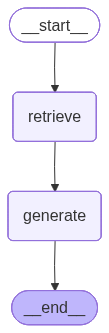

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = '선정인원은 몇명이야?'
initial_state = {'query': query}
result = graph.invoke(initial_state)

{'query': '선정인원은 몇명이야?',
 'context': [Document(id='0418c963-1b95-47cc-8394-3c4345b4c296', metadata={'source': './documents/청년월세지원.txt'}, page_content='지원대상 선정 기준\n선정인원 : 15,000명\n선정방법 : 임차보증금·월세 및 소득기준, 4개 구간으로 나누어 선정\n  인원 초과 시, 구간별 전산추첨 선정\n구간별 미달인 경우, 1구간부터 4구간 순으로 추가 선정\n선정기준은 월세액, 임대차계약서에 표기된 차임(월세)액으로 함 (관리비 제외)\n차임(월세) 기준 월세 60만원 초과 시 보증금 월세 환산액(5.0%) 합산\n\n구간\n| 구간 | 임차보증금 및 월세액                | 소득기준          | 선정인원(명) |\n|------|----------------------------------|------------------|--------------|\n| 1    | 임차보증금 5백만원 이하이고, 월세 40만원 이하 | 120% 이하         | 6,750 (45%)  |\n| 2    | 임차보증금 1천만원 이하이고, 월세 50만원 이하 | 120% 이하         | 4,500 (30%)  |\n| 3    | 임차보증금 2천만원 이하이고, 월세 60만원 이하 | 150% 이하         | 2,250 (15%)  |\n| 4    | 임차보증금 3천만원 이하이고, 월세 60만원 이하 | 150% 이하         | 1,500 (10%)  |\n※ 월세 60만원 초과자 중 보증금 합계가 이하인 경우 보증금 세대주(현금 5.0%) 및 월세액 합계 93만원 이하\n5. 심사결과 발표\n\n일시: 2025년 8월 예정\n발표: 서울주자표원(https://housing.seoul.go.kr)‘마이페이지’ 내 청년월세지원 신청현황(이하 ‘마이페이지’)에서 확인, 개별 알림\n\n6. 이의신청\n\

In [25]:
result['answer'].content

'선정인원은 15,000명입니다.'